In [1]:
# experiment 1 of Davis et al. (2008)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import os
import scipy.io
plt.style.use("default")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
SAVEFIG = False

In [2]:
study_path = 'simu7_data/simu7_study/'
test_path = 'simu7_data/simu7_test/'
files = os.listdir(study_path)  # same name in test path
nitems = 24
npairs = 12

In [3]:
df = pd.DataFrame()
for f in files:
    
    # load subject data
    subjnum = int(f.lstrip('subj').rstrip('.mat'))
    study_mat = scipy.io.loadmat(os.path.join(study_path,f))['studymatrix']
    test_mat = scipy.io.loadmat(os.path.join(test_path,f))['theinfomatrix']
    nlists = study_mat.shape[-1]

    # get item's list and pos
    study_items_flat = study_mat.flatten(order='F')
    list_ids = np.repeat(np.arange(1, nlists + 1), nitems)
    list_pos = np.tile(np.arange(1, npairs + 1), nlists*2)
    item2list = {}
    item2pos = {}
    for i, item in enumerate(study_items_flat):
        item2list[item] = list_ids[i]
        item2pos[item] = list_pos[i]

    # reshape test mat
    for i in range(nlists):
        if i == 0:
            test_2d = test_mat[:,:,0]
        else:
            test_2d = np.concatenate((test_2d,test_mat[:,:,i]),axis=0)
    tmp_df = pd.DataFrame(test_2d)
    tmp_df.columns = ['test_item','response','pair_pos','lag','forward','correct','intrusion_type','rt']
    tmp_df['subjnum'] = subjnum
    tmp_df['list'] = np.repeat(np.arange(1,nlists+1),npairs)

    # get response type
    def get_intrusion_type(x):
        correctness = x['correct']
        response = x['response']
        if correctness == 1:
            return 'Correct'
        else:
            if response == 99999 or response < 0 or (response not in study_items_flat) or response == x['test_item']:
                return 'Out'
            else:
                resp_list = item2list[response]
                if resp_list == x['list']:
                    return 'ILI'
                elif resp_list < x['list']:
                    return 'PLI'
                else:
                    return 'Out'
    tmp_df['type'] = tmp_df.apply(get_intrusion_type, axis=1)

    # get response pos
    def get_resp_pos(x):
        resp_type = x['type']
        if resp_type == "Correct":
            return item2pos[x['response']]
            # return x['pair_pos']
        elif resp_type == 'ILI':
            return item2pos[x['response']]
        else:
            return None
    tmp_df['resp_pos'] = tmp_df.apply(get_resp_pos, axis=1)

    # get response list
    def get_resp_list(x):
        resp_type = x['type']
        if resp_type == "Correct" or resp_type == "ILI":
            return x['list']
        elif resp_type == "PLI":
            return item2list[x['response']]
        else:
            return None
    tmp_df['resp_list'] = tmp_df.apply(get_resp_list, axis=1)

    df = pd.concat([df,tmp_df])
df
# lag: the lag between the previous test item and the current test item

,test_item,response,pair_pos,lag,forward,correct,intrusion_type,rt,subjnum,list,type,resp_pos,resp_list
0,243.0,41.0,7.0,0.0,1.0,0.0,1.0,2414.0,59,1,ILI,2.0,1.0
1,41.0,87.0,2.0,-5.0,1.0,0.0,-1.0,2414.0,59,1,Out,NaN,NaN
2,37.0,302.0,3.0,1.0,0.0,0.0,1.0,2785.0,59,1,ILI,12.0,1.0
3,43.0,395.0,4.0,1.0,0.0,1.0,0.0,370.0,59,1,Correct,4.0,1.0
4,219.0,302.0,12.0,8.0,1.0,1.0,0.0,185.0,59,1,Correct,12.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,111.0,99999.0,9.0,-1.0,1.0,0.0,0.0,928.0,54,15,Out,NaN,NaN
176,318.0,99999.0,4.0,-5.0,1.0,0.0,0.0,3157.0,54,15,Out,NaN,NaN
177,79.0,-9999.0,12.0,8.0,0.0,0.0,2.0,0.0,54,15,Out,NaN,NaN
178,153.0,39.0,5.0,-7.0,1.0,1.0,0.0,0.0,54,15,Correct,5.0,15.0


In [4]:
np.unique(df.subjnum).shape

(75,)

In [5]:
df.groupby("subjnum")['list'].max()

subjnum
1      10
2      15
3      14
4      15
5      14
       ..
111    16
113    16
114    16
115    16
116    16
Name: list, Length: 75, dtype: int64

In [4]:
df.groupby("type").response.count()

type
Correct    9166
ILI         646
Out        3560
PLI         212
Name: response, dtype: int64

In [6]:
# count ILI and PLI to verify
df_cnt = df.groupby(['subjnum','type']).response.count().unstack(fill_value=0).stack().to_frame(name='count').reset_index()
df_cnt_ILI = df_cnt.query("type == 'ILI'").copy()
df_cnt_ILI['total'] = df.groupby("subjnum").test_item.count().tolist()
df_cnt_ILI['p'] = df_cnt_ILI['count'] / df_cnt_ILI['total']
df_cnt_ILI

,subjnum,type,count,total,p
1,1,ILI,2,120,0.016667
5,2,ILI,4,180,0.022222
9,3,ILI,0,168,0.000000
13,4,ILI,29,180,0.161111
17,5,ILI,9,168,0.053571
...,...,...,...,...,...
281,111,ILI,15,192,0.078125
285,113,ILI,2,192,0.010417
289,114,ILI,9,192,0.046875
293,115,ILI,9,192,0.046875


In [7]:
np.mean(df_cnt_ILI['p']), np.std(df_cnt_ILI['p'])

(0.0474728835978836, 0.042248188223357776)

In [8]:
df_cnt_PLI = df_cnt.query("type == 'PLI'").copy()
df_cnt_PLI['total'] = df.groupby("subjnum").test_item.count().tolist()
df_cnt_PLI['p'] = df_cnt_PLI['count'] / df_cnt_PLI['total']
df_cnt_PLI

,subjnum,type,count,total,p
3,1,PLI,2,120,0.016667
7,2,PLI,3,180,0.016667
11,3,PLI,0,168,0.000000
15,4,PLI,5,180,0.027778
19,5,PLI,0,168,0.000000
...,...,...,...,...,...
283,111,PLI,2,192,0.010417
287,113,PLI,1,192,0.005208
291,114,PLI,4,192,0.020833
295,115,PLI,1,192,0.005208


In [9]:
np.mean(df_cnt_PLI['p']), np.std(df_cnt_PLI['p'])

(0.015684523809523804, 0.01623327126336429)

In [10]:
# pos_lag and list_lag
df['pos_lag'] = df['resp_pos'] - df['pair_pos']
df['list_lag'] = df['resp_list'] - df['list']
df

,test_item,response,pair_pos,lag,forward,correct,intrusion_type,rt,subjnum,list,type,resp_pos,resp_list,pos_lag,list_lag
0,243.0,41.0,7.0,0.0,1.0,0.0,1.0,2414.0,59,1,ILI,2.0,1.0,-5.0,0.0
1,41.0,87.0,2.0,-5.0,1.0,0.0,-1.0,2414.0,59,1,Out,NaN,NaN,NaN,NaN
2,37.0,302.0,3.0,1.0,0.0,0.0,1.0,2785.0,59,1,ILI,12.0,1.0,9.0,0.0
3,43.0,395.0,4.0,1.0,0.0,1.0,0.0,370.0,59,1,Correct,4.0,1.0,0.0,0.0
4,219.0,302.0,12.0,8.0,1.0,1.0,0.0,185.0,59,1,Correct,12.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,111.0,99999.0,9.0,-1.0,1.0,0.0,0.0,928.0,54,15,Out,NaN,NaN,NaN,NaN
176,318.0,99999.0,4.0,-5.0,1.0,0.0,0.0,3157.0,54,15,Out,NaN,NaN,NaN,NaN
177,79.0,-9999.0,12.0,8.0,0.0,0.0,2.0,0.0,54,15,Out,NaN,NaN,NaN,NaN
178,153.0,39.0,5.0,-7.0,1.0,1.0,0.0,0.0,54,15,Correct,5.0,15.0,0.0,0.0


### PLI

In [11]:
# all PLIs
df.query("type == 'PLI'")

,test_item,response,pair_pos,lag,forward,correct,intrusion_type,rt,subjnum,list,type,resp_pos,resp_list,pos_lag,list_lag
38,161.0,197.0,4.0,-8.0,0.0,0.0,-1.0,2042.0,59,4,PLI,NaN,2.0,NaN,-2.0
47,161.0,197.0,4.0,-1.0,0.0,0.0,-1.0,1113.0,59,4,PLI,NaN,2.0,NaN,-2.0
123,360.0,263.0,6.0,-6.0,1.0,0.0,-1.0,1113.0,59,11,PLI,NaN,10.0,NaN,-1.0
129,181.0,263.0,6.0,-4.0,0.0,0.0,-1.0,1856.0,59,11,PLI,NaN,10.0,NaN,-1.0
144,254.0,297.0,8.0,0.0,0.0,0.0,-1.0,928.0,59,13,PLI,NaN,9.0,NaN,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,44.0,220.0,9.0,-1.0,1.0,0.0,-1.0,2414.0,40,4,PLI,NaN,3.0,NaN,-1.0
44,44.0,220.0,9.0,7.0,1.0,0.0,-1.0,742.0,40,4,PLI,NaN,3.0,NaN,-1.0
66,369.0,353.0,5.0,1.0,0.0,0.0,-1.0,3342.0,40,6,PLI,NaN,4.0,NaN,-2.0
118,440.0,296.0,10.0,6.0,1.0,0.0,-1.0,1671.0,40,10,PLI,NaN,3.0,NaN,-7.0


In [12]:
df_PLI = df.query("type == 'PLI' and list > 5 and  -6 < list_lag")
# df_PLI = df.query("type == 'PLI' and  list > 1 and -6 < list_lag < 0")
# df_PLI = df.query("type == 'PLI' and  list > 1 and list_lag < 0")
# df_PLI = df.query("type == 'PLI' and list > 5 and  list_lag < 0")
df_PLI

,test_item,response,pair_pos,lag,forward,correct,intrusion_type,rt,subjnum,list,type,resp_pos,resp_list,pos_lag,list_lag
123,360.0,263.0,6.0,-6.0,1.0,0.0,-1.0,1113.0,59,11,PLI,NaN,10.0,NaN,-1.0
129,181.0,263.0,6.0,-4.0,0.0,0.0,-1.0,1856.0,59,11,PLI,NaN,10.0,NaN,-1.0
144,254.0,297.0,8.0,0.0,0.0,0.0,-1.0,928.0,59,13,PLI,NaN,9.0,NaN,-4.0
170,404.0,77.0,7.0,-3.0,1.0,0.0,-1.0,0.0,71,15,PLI,NaN,14.0,NaN,-1.0
144,11.0,98.0,12.0,0.0,1.0,0.0,-1.0,742.0,73,13,PLI,NaN,10.0,NaN,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,171.0,119.0,2.0,-7.0,0.0,0.0,-1.0,3157.0,68,12,PLI,NaN,8.0,NaN,-4.0
136,131.0,445.0,12.0,10.0,0.0,0.0,-1.0,556.0,68,12,PLI,NaN,11.0,NaN,-1.0
138,235.0,190.0,6.0,-5.0,1.0,0.0,-1.0,9844.0,68,12,PLI,NaN,7.0,NaN,-5.0
143,27.0,190.0,3.0,1.0,0.0,0.0,-1.0,6315.0,68,12,PLI,NaN,7.0,NaN,-5.0


In [13]:
len(np.unique(df_PLI.subjnum)) # in paper, it should be 39

42

In [14]:
df_PLI_subjcnt = df_PLI.groupby(["subjnum","list_lag"]).response.count().unstack(fill_value=0).stack().to_frame(name='count').reset_index()
df_PLI_subjsum = df_PLI_subjcnt.groupby("subjnum")['count'].sum().to_frame(name="sum").reset_index()
df_PLI_subj = pd.merge(df_PLI_subjcnt, df_PLI_subjsum, on="subjnum")
df_PLI_subj['p_PLI'] = df_PLI_subj['count'] / df_PLI_subj['sum']
df_PLI_subj

,subjnum,list_lag,count,sum,p_PLI
0,1,-5.0,0,1,0.0
1,1,-4.0,0,1,0.0
2,1,-3.0,0,1,0.0
3,1,-2.0,0,1,0.0
4,1,-1.0,1,1,1.0
...,...,...,...,...,...
205,114,-5.0,0,2,0.0
206,114,-4.0,1,2,0.5
207,114,-3.0,0,2,0.0
208,114,-2.0,0,2,0.0


In [15]:
df_PLIgp = df_PLI_subj.groupby("list_lag").p_PLI.mean().to_frame(name='PLI_prob').reset_index()
df_PLIgp['list_abs_lag'] = np.abs(df_PLIgp['list_lag'])
df_PLIgp

,list_lag,PLI_prob,list_abs_lag
0,-5.0,0.075028,5.0
1,-4.0,0.195153,4.0
2,-3.0,0.162698,3.0
3,-2.0,0.240334,2.0
4,-1.0,0.326786,1.0


In [16]:
# PLI_num = df_PLI.shape[0]
# df_PLIgp = df_PLI.groupby("list_lag")['test_item'].count().to_frame(name='PLI_cnt').reset_index()
# df_PLIgp['list_abs_lag'] = np.abs(df_PLIgp['list_lag'])
# df_PLIgp['PLI_prob'] = df_PLIgp['PLI_cnt'] / PLI_num
# df_PLIgp

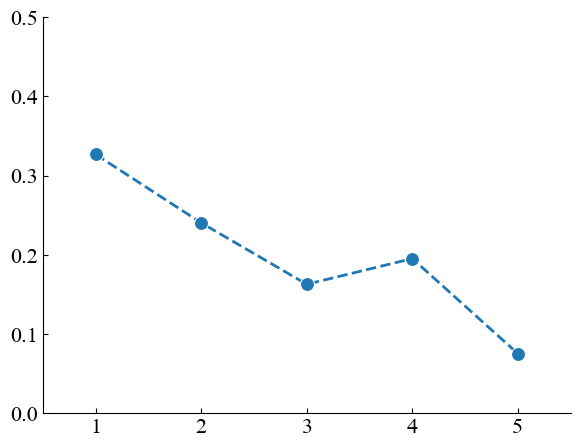

In [17]:
fig, ax = plt.subplots(figsize=(6,4.5))
fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_PLIgp.query("list_abs_lag < 6"), x='list_abs_lag', y='PLI_prob', linewidth=2, marker='o', markersize = 10, linestyle = '--')
plt.ylim([0,0.5])
plt.xlim([0.5,5.5])
plt.xticks(ticks=np.arange(1,6))
plt.yticks(ticks=np.arange(0,0.6,0.1),labels=np.arange(0,0.6,0.1).round(decimals=2))
plt.xlabel('Lag')
plt.ylabel('PLI Probablility')
ax.set(xlabel=None, ylabel=None)

if SAVEFIG:
    plt.savefig('simu7_fig/simu7_Davis_PLI.pdf')

### ILI

In [18]:
df_ILI = df.query("type == 'ILI' and list > 1")

# exclude subjects who has less than 4 responses in df_ILI
df_ILI_subjcnt = df_ILI.groupby("subjnum").response.count().to_frame(name='count').reset_index()
df_ILI_subjcnt = df_ILI_subjcnt.query("count >= 4")
df_ILI = df_ILI[df_ILI.subjnum.isin(df_ILI_subjcnt.subjnum)]
df_ILI

,test_item,response,pair_pos,lag,forward,correct,intrusion_type,rt,subjnum,list,type,resp_pos,resp_list,pos_lag,list_lag
13,63.0,197.0,6.0,1.0,0.0,0.0,1.0,2599.0,59,2,ILI,10.0,2.0,4.0,0.0
22,435.0,30.0,6.0,-1.0,1.0,0.0,1.0,928.0,59,2,ILI,5.0,2.0,-1.0,0.0
29,151.0,120.0,6.0,-3.0,1.0,0.0,1.0,1113.0,59,3,ILI,5.0,3.0,-1.0,0.0
33,332.0,286.0,6.0,-3.0,0.0,0.0,1.0,2042.0,59,3,ILI,10.0,3.0,4.0,0.0
52,156.0,169.0,1.0,-1.0,1.0,0.0,1.0,1113.0,59,5,ILI,5.0,5.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,315.0,366.0,5.0,1.0,1.0,0.0,1.0,1671.0,54,13,ILI,4.0,13.0,-1.0,0.0
155,452.0,199.0,3.0,-3.0,0.0,0.0,1.0,5943.0,54,13,ILI,2.0,13.0,-1.0,0.0
162,423.0,8.0,1.0,-1.0,0.0,0.0,1.0,5200.0,54,14,ILI,4.0,14.0,3.0,0.0
165,163.0,8.0,12.0,1.0,0.0,0.0,1.0,3157.0,54,14,ILI,4.0,14.0,-8.0,0.0


In [19]:
len(np.unique(df_ILI.subjnum))

48

In [20]:
# df_tmp = df_ILI.query("subjnum == 59")
# df_tmp1 = df_tmp.groupby("pos_lag").response.count().to_frame(name='ILI_cnt')
# df_tmp1

In [21]:
# possible_ILI_cnt = {}
# for pair_pos in df_tmp.pair_pos:
#     l_bound = -pair_pos + 1
#     r_bound = npairs - pair_pos
#     for i in np.arange(l_bound, r_bound + 1):
#         if i in possible_ILI_cnt:
#             possible_ILI_cnt[i] += 1
#         else:
#             possible_ILI_cnt[i] = 1
# possible_ILI_cnt

In [22]:
# df_tmp1['poss_ILI_cnt'] = pd.Series(possible_ILI_cnt)
# df_tmp1['ILI_prob'] = df_tmp1['ILI_cnt'] / df_tmp1['poss_ILI_cnt']
# df_tmp1 = df_tmp1.reset_index()
# df_tmp1

In [23]:
def cal_ILI(df_tmp):
    df_tmp1 = df_tmp.groupby("pos_lag").response.count().to_frame(name='ILI_cnt')

    possible_ILI_cnt = {}
    for pair_pos in df_tmp.pair_pos:
        l_bound = -pair_pos + 1
        r_bound = npairs - pair_pos
        for i in np.arange(l_bound, r_bound + 1):
            if i in possible_ILI_cnt:
                possible_ILI_cnt[i] += 1
            else:
                possible_ILI_cnt[i] = 1
    
    df_tmp1['poss_ILI_cnt'] = pd.Series(possible_ILI_cnt)
    df_tmp1['ILI_prob'] = df_tmp1['ILI_cnt'] / df_tmp1['poss_ILI_cnt']
    df_tmp1 = df_tmp1.reset_index()
    return df_tmp1

In [24]:
df_ILIprob = df_ILI.groupby("subjnum").apply(cal_ILI).reset_index()
df_ILIprob = df_ILIprob.query("pos_lag >= -5 and pos_lag <= 5")

# fill 0 for missing pos_lag
df_ILIprob['pos_lag'] = df_ILIprob['pos_lag'].astype(int)
df_ILIprob = df_ILIprob.pivot(index='subjnum',columns='pos_lag',values='ILI_prob').fillna(0)
df_ILIprob.reset_index(inplace=True)
df_ILIprob = df_ILIprob.melt(id_vars='subjnum', value_name='ILI_prob').rename(columns={'variable':'pos_lag'})
df_ILIprob

/var/folders/js/fb9kwys10ln8jgq1bxxqg0tr0000gn/T/ipykernel_66146/1463952016.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ILIprob = df_ILI.groupby("subjnum").apply(cal_ILI).reset_index()


,subjnum,pos_lag,ILI_prob
0,2,-5,0.000000
1,4,-5,0.058824
2,5,-5,0.000000
3,6,-5,0.000000
4,7,-5,0.111111
...,...,...,...
475,107,5,0.166667
476,110,5,0.000000
477,111,5,0.200000
478,114,5,0.000000


In [25]:
df_ILIgp = df_ILIprob.groupby("pos_lag").ILI_prob.mean().to_frame(name='ILI_prob').reset_index()
df_ILIgp

,pos_lag,ILI_prob
0,-5,0.047524
1,-4,0.084719
2,-3,0.083509
3,-2,0.094783
4,-1,0.148602
5,1,0.211547
6,2,0.085749
7,3,0.105633
8,4,0.088677
9,5,0.050863


In [26]:
# possible_ILI_cnt = {}
# for pair_pos in df_ILI.pair_pos:
# # for pair_pos in df.pair_pos:  # impossible! too small.
#     l_bound = -pair_pos + 1
#     r_bound = 12 - pair_pos
#     for i in np.arange(l_bound, r_bound + 1):
#         if i in possible_ILI_cnt:
#             possible_ILI_cnt[i] += 1
#         else:
#             possible_ILI_cnt[i] = 1
# # possible_ILI_cnt

In [27]:
# df_ILIgp = df_ILI.groupby("pos_lag")['test_item'].count().to_frame(name='ILI_cnt')
# df_ILIgp['poss_ILI_cnt'] = pd.Series(possible_ILI_cnt)
# df_ILIgp['ILI_prob'] = df_ILIgp['ILI_cnt'] / df_ILIgp['poss_ILI_cnt']
# df_ILIgp

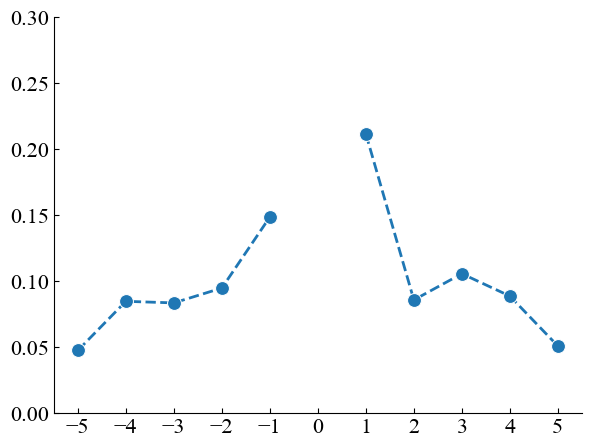

In [28]:
fig, ax = plt.subplots(figsize=(6,4.5))
fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")

sns.lineplot(data=df_ILIgp.query("-6 < pos_lag < 0"), x='pos_lag', y='ILI_prob', linewidth=2, marker='o', markersize = 10,color='C0', linestyle = '--')
sns.lineplot(data=df_ILIgp.query("0 < pos_lag < 6"), x='pos_lag', y='ILI_prob', linewidth=2, marker='o', markersize = 10,color='C0', linestyle = '--')
plt.ylim([0,0.3])
plt.xticks(ticks=np.arange(-5,6))
plt.xlabel('Lag')
plt.ylabel('Intrusion Conditional Response Probablility')
ax.set(xlabel=None, ylabel=None)

if SAVEFIG:
    plt.savefig('simu7_fig/simu7_Davis_ILI.pdf')